This is Junmo Koo's DSCI 100 project

In [41]:
library(tidyverse)
library(caret) 
library(rsample)  
library(recipes) 
library(tidymodels) 
library(class) 

In [42]:
#load dataset
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [43]:
#check how the dataset looks like
head(players)
head(sessions)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [44]:
# Since I will be doing
# Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

# I will clean the 'players.csv' data

players_data <- players_data |>
  filter(!is.na(subscribe), !is.na(Age), !is.na(played_hours)) |>
  # since 'subscribe' is factor for our classification
  mutate(subscribe = factor(subscribe))

In [45]:
#Splitting Data
set.seed(123)

#split it into testing and training (70% vs 30%)
data_split <- initial_split(players_data, prop = 0.7)
train_data <- training(data_split)
test_data <- testing(data_split)

# Define the recipe
knn_recipe <- recipe(subscribe ~ Age + played_hours, data = train_data) |>
  step_normalize(all_numeric_predictors())

# Define the KNN
knn_spec <- nearest_neighbor(mode = "classification", neighbors = tune()) |>
  set_engine("kknn")

# Define the workflow
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)

#Cross-Validation
cv_folds <- vfold_cv(train_data, v = 5) # 5-fold cross-validation

#range of k to tune
k_grid <- tibble(neighbors = seq(1, 15, by = 2))


#
tune_results <- knn_workflow |>
      tune_grid(
      resamples = cv_folds,
      grid = k_grid,
      metrics = metric_set(accuracy))

#midway checking
print(tune_results)

tune_metrics <- tune_results |>
  collect_metrics()

#find K with highest accuracy
best_k <- tune_metrics |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

best_k # I checked and it was 13.

tune_metrics |>
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "KNN Model Tuning: Accuracy vs. k", x = "Number of Neighbors (k)", y = "Accuracy")

ERROR: [1m[33mError[39m in `metric_set()`:[22m
[1m[22m[33m![39m All inputs to `metric_set()` must be functions. These inputs are not:
  1.


In [46]:
#After finding the best K-value

knn_spec_best <- nearest_neighbor(mode = "classification", neighbors = best_k) |>
  set_engine("kknn")

knn_workflow_best <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec_best)

knn_fit <- fit(knn_workflow_best, data = train_data)

predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

head(predictions)

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
TRUE,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
TRUE,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
TRUE,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
TRUE,Veteran,TRUE,bbe2d83de678f519c4b3daa7265e683b4fe2d814077f9094afd11d8f217039ec,0.0,Nyla,Female,22
TRUE,Veteran,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23
TRUE,Veteran,TRUE,6f9acf8ea9956fe817895c78d10e1e25c11aba335a451e5b0322b073ee5008c4,0.0,Niamh,Non-binary,17


In [47]:
# Calculate confusion matrix
confusion_matrix <- conf_mat(predictions, truth = subscribe, estimate = .pred_class)

# Print confusion matrix and other performance metrics
confusion_matrix

accuracy <- accuracy(predictions, truth = subscribe, estimate = .pred_class)
print(accuracy)

          Truth
Prediction FALSE TRUE
     FALSE     4    2
     TRUE      9   44

# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.814


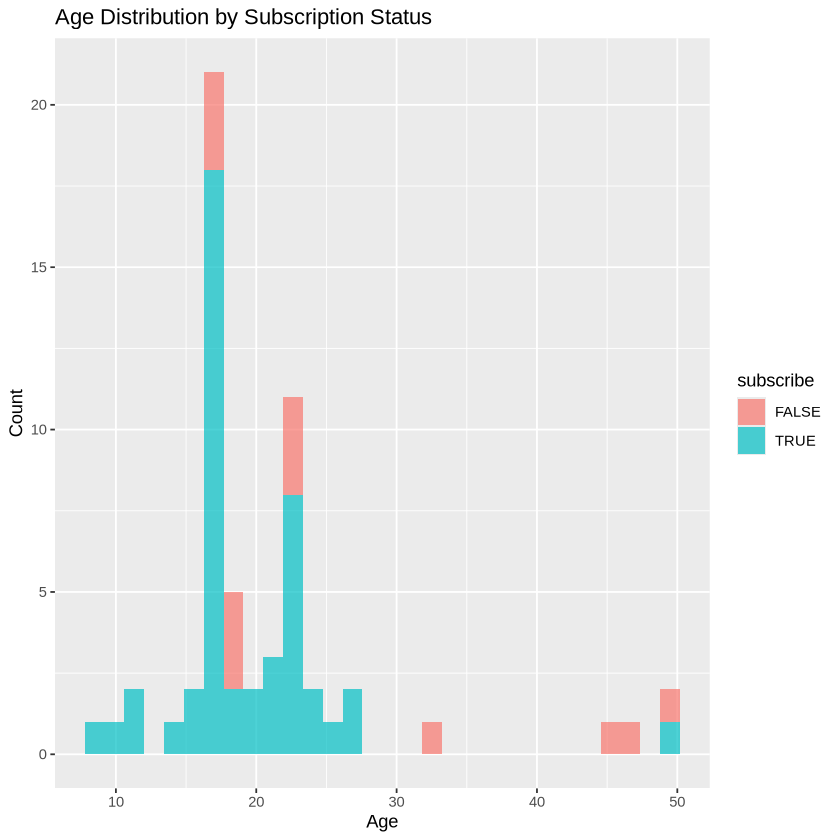

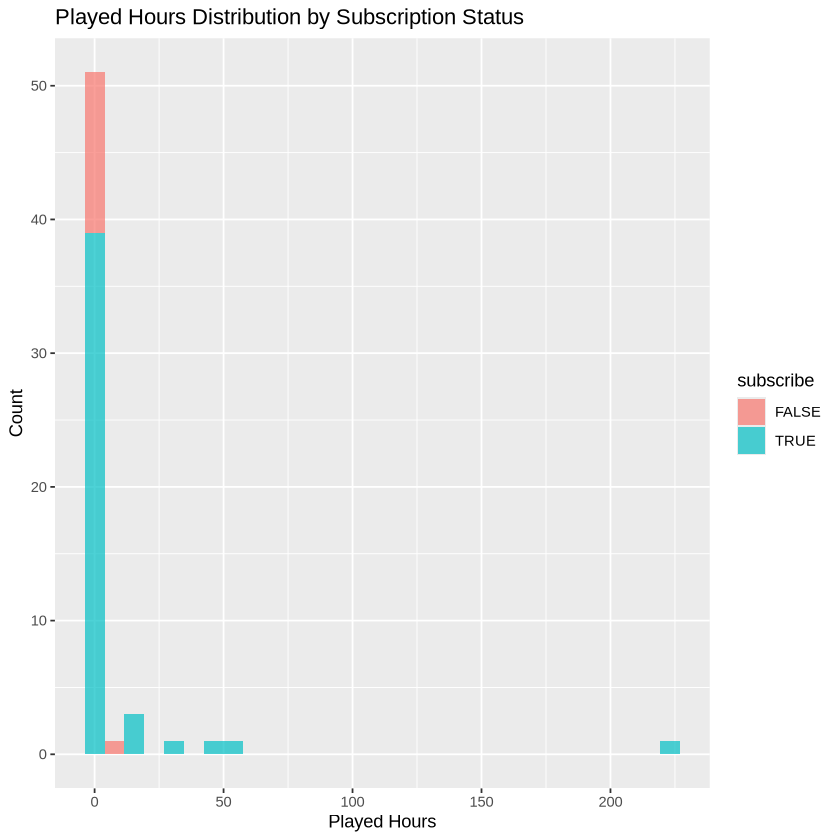

In [48]:
# Visualizing Age vs Subscription status
ggplot(predictions, aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 30, alpha = 0.7) +
  labs(title = "Age Distribution by Subscription Status", x = "Age", y = "Count")

# Visualizing Played Hours vs Subscription status
ggplot(predictions, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 30, alpha = 0.7) +
  labs(title = "Played Hours Distribution by Subscription Status", x = "Played Hours", y = "Count")
